# 1 Import Packages

In [1]:
import xarray as xr
import numpy as np
import os
import datetime


import src.config as config
import src.utils as utils

import math
from tqdm import tqdm

import innvestigate
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import tensorflow as tf
tf.compat.v1.disable_eager_execution()


2023-02-21 17:25:08.835568: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2 Metadata

In [2]:
lev_index   = 0
kfold_index = 0
exp_name    = "cv"
datetime_string = datetime.datetime.now().strftime("%d_%m_%Y_%H_%M_%S")


In [3]:
# Parameters
lev_index = "0"
kfold_index = "0"
datetime_string = "20_02_2023_16_16_46"


In [4]:
model_name = "conv_level_{}_experiment_{}".format(lev_index, datetime_string)
model_path = os.path.join(config.model_path,exp_name, model_name)
os.makedirs(model_path, exist_ok=True)

In [5]:
ml_transform_path = os.path.join(config.data_pro_path,"ml_transform", exp_name)

In [6]:
train_x_filename = "train_data_stack_lonlatstandardized_lev_{}_{}.nc".format(lev_index, kfold_index)
valid_x_filename = "valid_data_stack_lonlatstandardized_lev_{}_{}.nc".format(lev_index, kfold_index)

train_y_filename = "train_data_amoc_depth_1020_lat_26_samplestandardized_{}_{}.nc".format(lev_index, kfold_index)
valid_y_filename = "valid_data_amoc_depth_1020_lat_26_samplestandardized_{}_{}.nc".format(lev_index, kfold_index)

# 3 Load Data

In [7]:
train_x_xr = xr.open_dataset(os.path.join(ml_transform_path, train_x_filename))
valid_x_xr = xr.open_dataset(os.path.join(ml_transform_path, valid_x_filename))

In [8]:
train_y_xr = xr.open_dataset(os.path.join(ml_transform_path, train_y_filename))
valid_y_xr = xr.open_dataset(os.path.join(ml_transform_path, valid_y_filename))

In [9]:
train_data_amoc_depth_1020_lat_26_samplestd  = xr.load_dataset(os.path.join(ml_transform_path, train_y_filename ))
train_data_amoc_depth_1020_lat_26_samplemean = xr.load_dataset(os.path.join(ml_transform_path, valid_y_filename))

# 4 Processing

In [10]:
train_x_xr_stack = train_x_xr.stack(sample=("realization","time"))
valid_x_xr_stack = valid_x_xr.stack(sample=("realization","time"))

In [11]:
train_y_xr_stack = train_y_xr.stack(sample=("realization","time"))
valid_y_xr_stack = valid_y_xr.stack(sample=("realization","time"))


In [12]:
valid_sample_coords = valid_y_xr_stack.sample
train_sample_coords = train_y_xr_stack.sample

train_x_ml_np = np.nan_to_num(np.expand_dims(train_x_xr_stack["rho"].transpose("sample",...).values,3),0)
valid_x_ml_np = np.nan_to_num(np.expand_dims(valid_x_xr_stack["rho"].transpose("sample",...).values,3),0)

train_y_ml_np = train_y_xr_stack["atlantic_moc"].values
valid_y_ml_np = valid_y_xr_stack["atlantic_moc"].values

In [13]:
train_data_amoc_depth_1020_lat_26_samplestd  = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplestd.nc" ))
train_data_amoc_depth_1020_lat_26_samplemean = xr.load_dataset(os.path.join(ml_transform_path,"train_data_amoc_depth_1020_lat_26_samplemean,nc"))

In [14]:
lon = train_x_xr_stack.lon
lat = train_x_xr_stack.lat

# 5 Model

In [74]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(10,(3,3), activation="relu", padding="same",input_shape=(120,121,1)))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(10,(3,3), activation="relu", padding="same", input_shape=(60,60,8)))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(10,(3,3), activation="relu", padding="same", input_shape=(30,30,32)))
#model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())

#model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(20, activation="relu"))
#model.add(tf.keras.layers.BatchNormalization())

#model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.Dense(10, activation="relu"))
#model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1, activation="linear"))

In [75]:
model.build()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 120, 121, 10)      100       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 60, 60, 10)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 60, 10)        910       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 10)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 30, 10)        910       
                                                                 
 flatten_3 (Flatten)         (None, 9000)             

In [76]:
model_file_template = os.path.join(model_path, "saved-model-{epoch:02d}.hdf5")
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file_template, monitor='val_mse', verbose=1, save_best_only=False, mode='max')

In [77]:
from tensorflow.keras.callbacks import Callback

class TrainValMSEDiff(Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        train_mse = model.evaluate(train_x_ml_np, train_y_ml_np)
        valid_mse = model.evaluate(valid_x_ml_np, valid_y_ml_np)
        diff_mse  = train_mse - valid_mse
        
        logs["train_mse_epoch_end"] = train_mse
        logs["valid_mse_epoch_end"] = valid_mse
        logs["diff_mse_epoch_end"] = diff_mse
        print(f'Epoch {epoch+1} - train_mse: {train_mse:.4f} - val_mse: {valid_mse:.4f} - diff: {diff_mse:.4f}')


In [78]:
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(model_path, "history.csv"))

In [79]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = os.path.join(model_path,"logs"))

# Train Model

In [80]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer = opt, loss=tf.keras.losses.mse)

In [81]:
model.fit(x=train_x_ml_np, y=train_y_ml_np, batch_size=64, epochs=1000, validation_data=(valid_x_ml_np, valid_y_ml_np), callbacks = [])#[TrainValMSEDiff(), checkpoint, csv_logger, tensorboard_callback])


Train on 13600 samples, validate on 2000 samples
Epoch 1/1000
13600/13600 [==============================] - ETA: 0s - loss: 0.7547

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


13600/13600 [==============================] - 117s 9ms/sample - loss: 0.7547 - val_loss: 0.6158
Epoch 2/1000
13600/13600 [==============================] - 118s 9ms/sample - loss: 0.5387 - val_loss: 0.5241
Epoch 3/1000
13600/13600 [==============================] - 117s 9ms/sample - loss: 0.4937 - val_loss: 0.5533
Epoch 4/1000
13600/13600 [==============================] - 118s 9ms/sample - loss: 0.4674 - val_loss: 0.5485
Epoch 5/1000
13600/13600 [==============================] - 118s 9ms/sample - loss: 0.4502 - val_loss: 0.5009
Epoch 6/1000
13600/13600 [==============================] - 116s 9ms/sample - loss: 0.4441 - val_loss: 0.4453
Epoch 7/1000
13600/13600 [==============================] - 117s 9ms/sample - loss: 0.4066 - val_loss: 0.4285
Epoch 8/1000
13600/13600 [==============================] - 153s 11ms/sample - loss: 0.4173 - val_loss: 0.4381
Epoch 9/1000
13600/13600 [==============================] - 225s 17ms/sample - loss: 0.3979 - val_loss: 0.4299
Epoch 10/1000
13600/1

KeyboardInterrupt: 

# Evaluation

(0.2, 1.0)

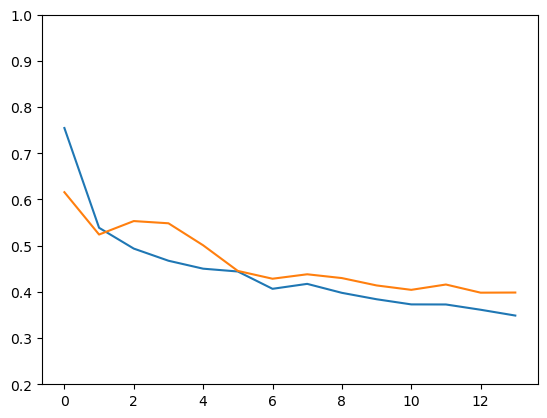

In [82]:
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])
plt.ylim(0.2,1)

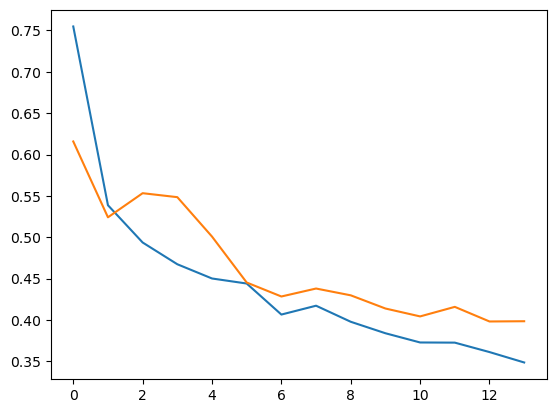

In [83]:
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])


In [84]:
plt.plot(model.history.history["train_mse_epoch_end"])
plt.plot(model.history.history["valid_mse_epoch_end"])
plt.plot(model.history.history["diff_mse_epoch_end"])

KeyError: 'train_mse_epoch_end'

## Weights 

In [85]:
weights_first_conv = model.layers[0].get_weights()[0]

In [86]:
n_conv = weights_first_conv.shape[3]

In [87]:
n_cols = math.floor(np.sqrt(n_conv))
n_rows = math.ceil(np.sqrt(n_conv))

IndexError: index 10 is out of bounds for axis 3 with size 10

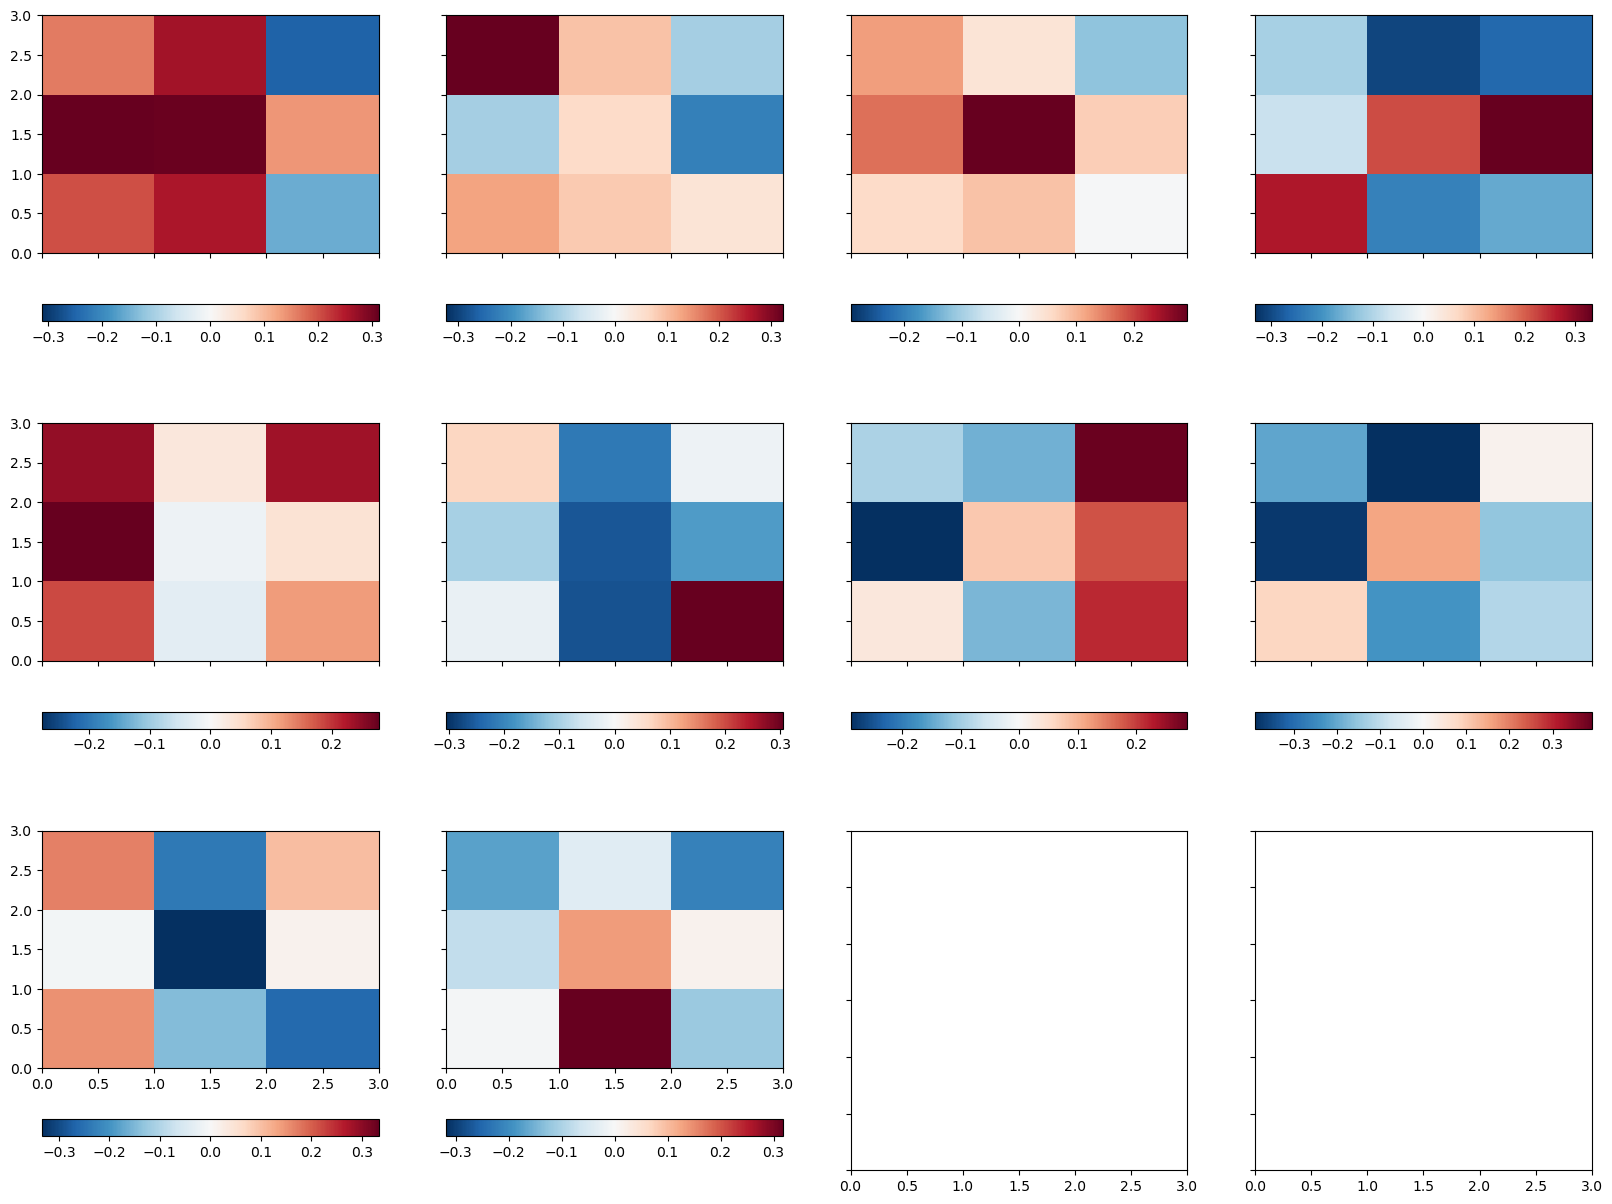

In [88]:
fig, ax = plt.subplots(n_cols, n_rows, sharex=True, sharey=True, figsize=(n_rows*5, n_cols*5))

ax_ravel = np.ravel(ax)
for i, ax in enumerate(ax_ravel):
    tmp = weights_first_conv[:,:,0,i]
    vmax = np.abs(tmp).max()
    plot = ax.pcolormesh(tmp, vmin = -vmax, vmax= vmax, cmap="RdBu_r")
    plt.colorbar(plot, ax = ax, orientation="horizontal")

In [89]:
intermediate_layer_model = tf.keras.Model(inputs=model.input,outputs=model.layers[0].output)

In [90]:
int_media_layer_pred = intermediate_layer_model.predict(train_x_ml_np)

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [91]:
n_hidden_layers = int_media_layer_pred.shape[-1]

IndexError: index 10 is out of bounds for axis 3 with size 10

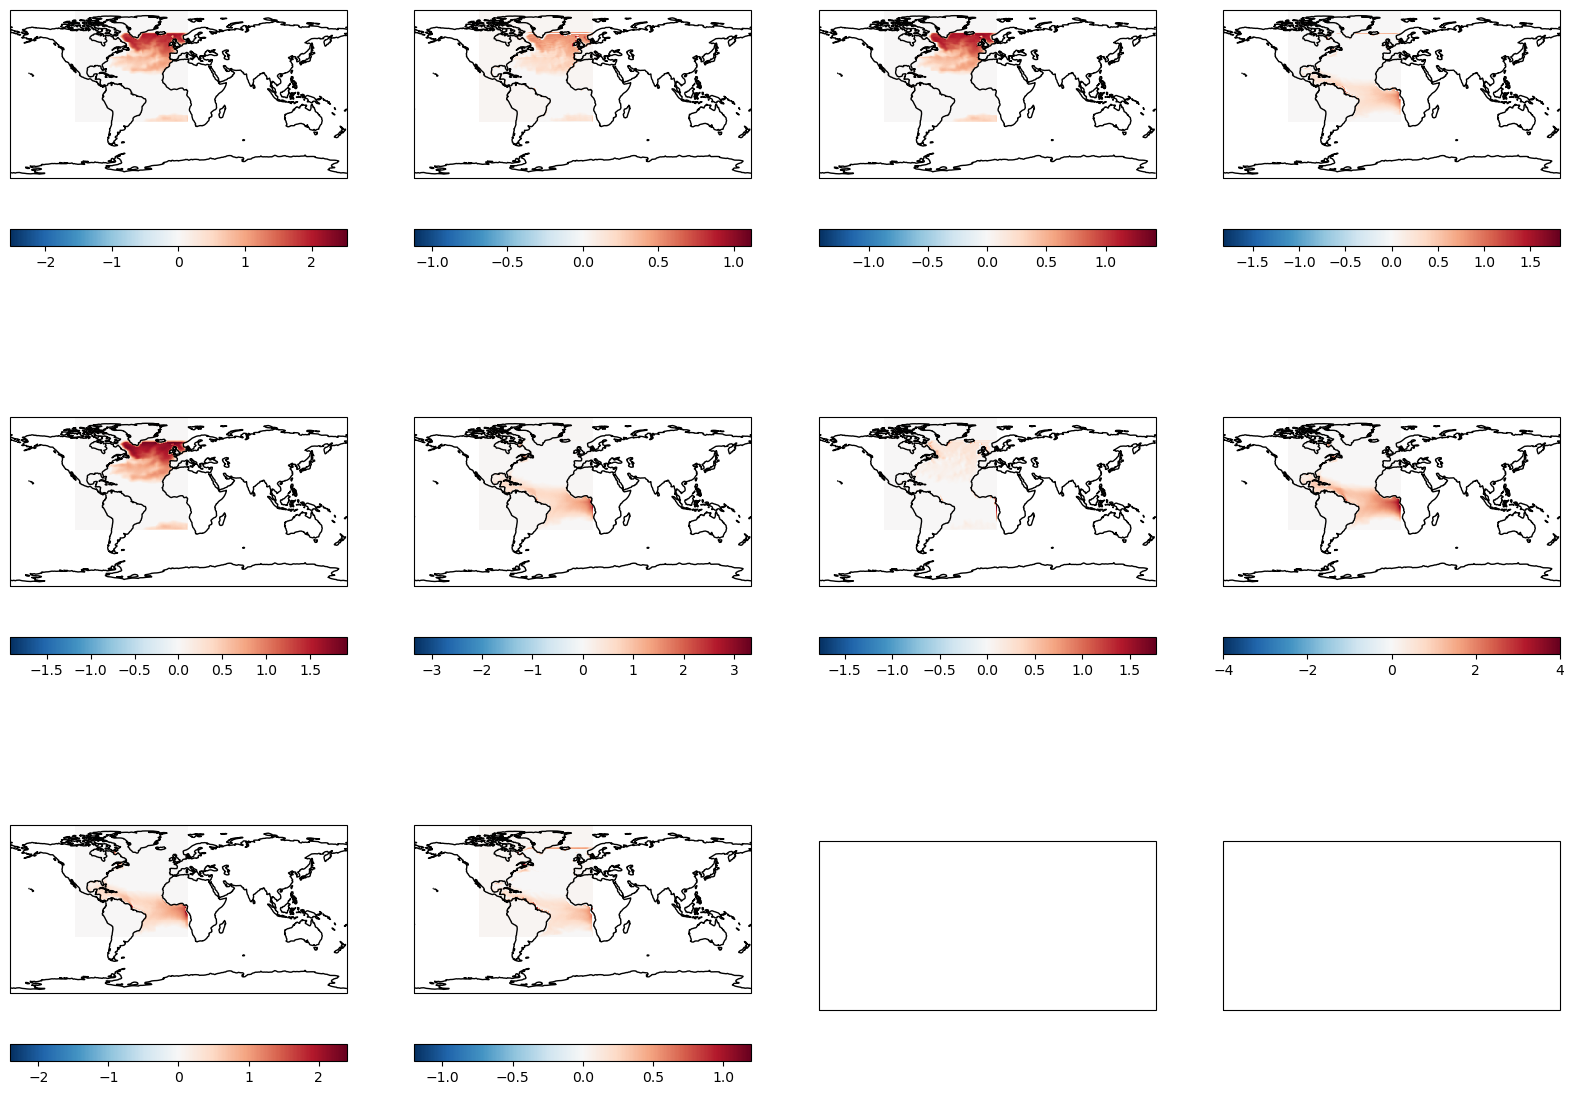

In [92]:
fig, ax = plt.subplots(n_cols, n_rows, sharex=True, sharey=True, figsize=(n_rows*5, n_cols*5), subplot_kw = {"projection":ccrs.PlateCarree()})

ax_ravel = np.ravel(ax)
for i, ax in enumerate(ax_ravel):
    tmp = int_media_layer_pred[1,:,:,i]
    vmax = np.abs(tmp).max()
    plot = ax.pcolormesh(lon, lat, tmp, vmin = -vmax, vmax= vmax, cmap="RdBu_r", transform=ccrs.PlateCarree())
    ax.coastlines()
    plt.colorbar(plot, ax = ax, orientation="horizontal")

In [93]:
y_train_pred = model.predict(train_x_ml_np)
y_train_true = train_y_ml_np

y_valid_pred = model.predict(valid_x_ml_np)
y_valid_true = valid_y_ml_np

/work/uo1075/u301101/programming/miniconda3/envs/CNN/lib/python3.8/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(0.0, 100.0)

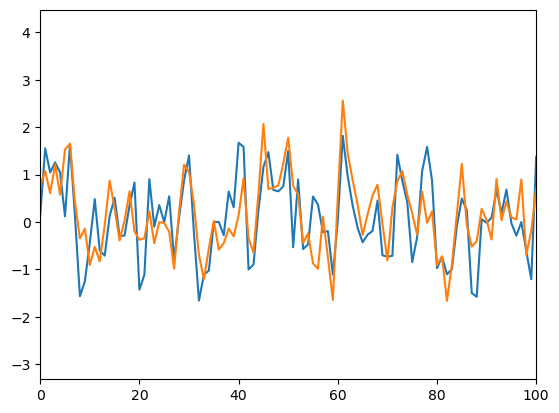

In [94]:
plt.plot(y_valid_true)
plt.plot(y_valid_pred)

plt.xlim(0,100)

(0.0, 100.0)

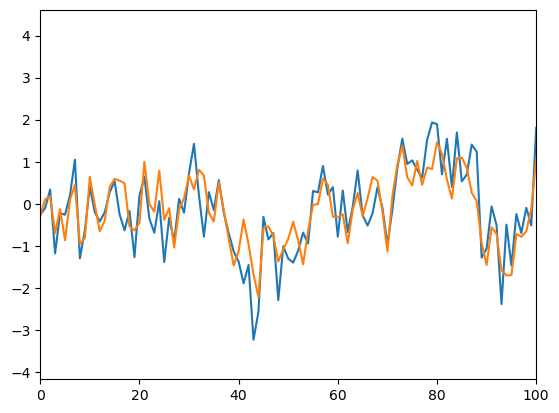

In [95]:
plt.plot(y_train_true)
plt.plot(y_train_pred)

plt.xlim(0,100)

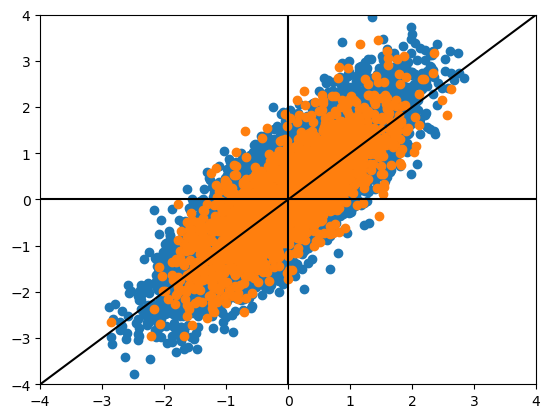

In [96]:
plt.scatter(y_train_pred, y_train_true)
plt.scatter(y_valid_pred, y_valid_true)

x = np.arange(-4,4+1)

plt.plot(x,x, color="black")
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.axhline(0, color="black")
plt.axvline(0, color="black")

In [97]:
analyzer = innvestigate.create_analyzer("lrp.epsilon", model)

In [98]:
heatmaps = analyzer.analyze(train_x_ml_np[:,:,:,:])
heatmaps_xr = xr.DataArray(np.squeeze(heatmaps), name="heatmap", dims = ["sample", "lat","lon"], coords = {"sample":train_sample_coords, "lon":lon,"lat":lat})

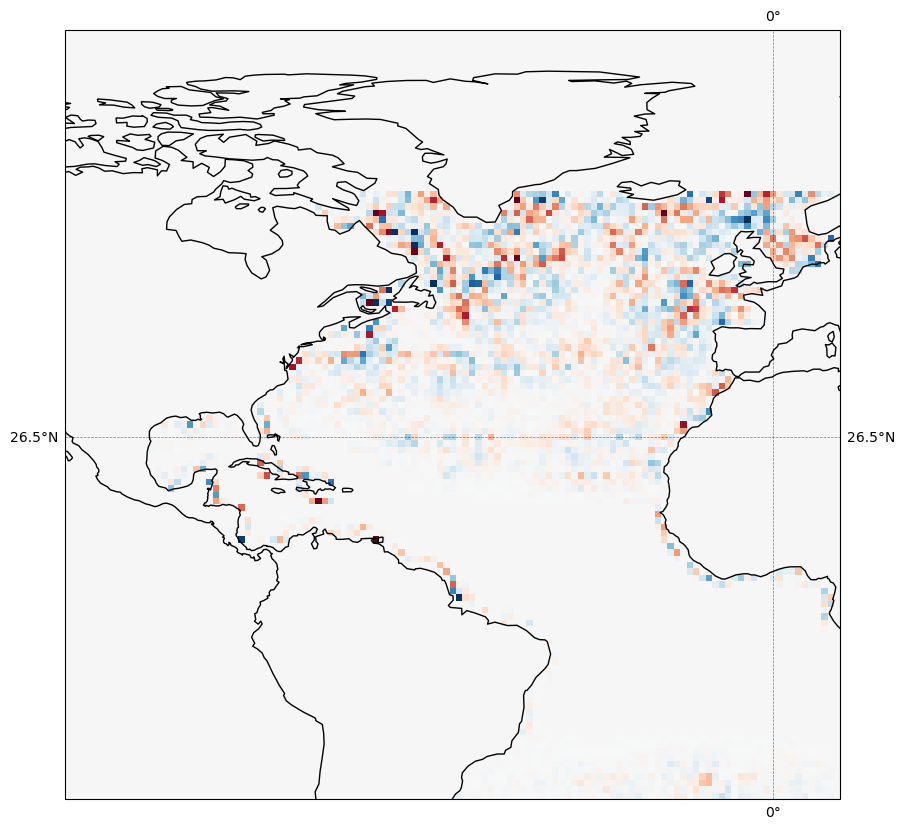

In [73]:
fig, ax = plt.subplots(1,1, figsize=(10,10), subplot_kw={"projection":ccrs.PlateCarree()})

tmp = heatmaps_xr.isel(sample=23)
vmax = np.abs(tmp).quantile(0.999)


ax.pcolormesh(lon, lat, tmp.transpose("lat","lon"), vmin=-vmax, vmax=vmax, transform=ccrs.PlateCarree(),cmap="RdBu_r")
ax.gridlines(xlocs=[0], ylocs = [26.5], draw_labels=True, linewidth=0.5, color='k', alpha=0.5, linestyle='--')

ax.coastlines()

